In [74]:
import numpy as np
import cvxpy as cp
 
import matplotlib.pyplot as plt
import plot_params
plt.rcParams.update(plot_params.fig_params) 

from utils.kernels import Kernel_se

np.random.seed(100) #100
save_file_name = "norm_est"

In [75]:
def rkhs_norm_noiseless(fX, X):
    k = Kernel_se()
    jitter = 1e-5
    K = k(X,X) + jitter*np.eye(X.shape[0])
    return np.sqrt(fX.T @ np.linalg.solve(K, fX))

class Ground_truth():
    
    def __init__(self):

        self.x_min = -5
        self.x_max = 5
        self.n_components = 100       
        self.kernel = Kernel_se()
        self.centers = np.random.uniform(low=self.x_min, high=self.x_max, size=(self.n_components,)) 
        self.coefficients = np.random.uniform(low=-2, high=2, size=(self.n_components,))
        
    def __call__(self, x):
        
        a = self.kernel(self.centers.reshape(-1,1), x.reshape(-1,1))
        b = self.coefficients.reshape(-1,1)
        return a.T @ b
    
    @property
    def rkhs_norm(self):
        alpha = self.coefficients.reshape(-1,1)
        X = self.centers.reshape(-1,1)
        return np.sqrt(alpha.T @ self.kernel(X,X) @ alpha)

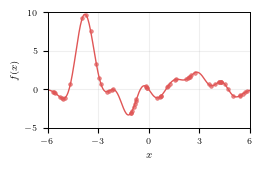

In [76]:
f = Ground_truth()
density = 300
x_aug_factor = 1.2
xx = np.linspace(f.x_min*x_aug_factor, f.x_max*x_aug_factor, density)
fxx = f(xx)

n_samples = 60
x_samples = np.random.uniform(f.x_min*x_aug_factor, f.x_max*x_aug_factor, size=(n_samples,))    

plt.plot(xx,fxx, color=plot_params.polt_colors['pastel_red'])
plt.scatter(x_samples, f(x_samples), 
            s=7, lw=0.5, alpha=0.7, 
            c=plot_params.polt_colors['pastel_red'], 
            edgecolors=plot_params.polt_colors['pastel_red'])

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.xticks(np.linspace(-6,6,5))
plt.yticks([-5, 0, 5, 10])
plt.ylim(-5,10)
plt.savefig("".join([plot_params.path_to_img_folder, save_file_name, ".pdf"]), bbox_inches='tight')#, pad_inches = 0)

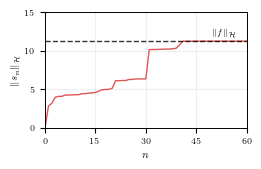

In [77]:
norm = np.array([rkhs_norm_noiseless(f(x_samples[0:n]),x_samples[0:n]) for n in range(1,n_samples+1)]).reshape(-1,1)

plt.plot(np.arange(0, n_samples+1), np.append(0, norm), color=plot_params.polt_colors['pastel_red'])

plt.axhline(y = f.rkhs_norm, color='k', linestyle='--', alpha=0.8)
plt.xticks([0, 15, 30, 45, 60])
plt.xlim(0, 60)
plt.yticks([0, 5, 10, 15])
plt.ylim(0, 15)
plt.xlabel("$n$")
plt.ylabel("$\Vert s_n \Vert_\mathcal{H}$")
plt.text(50, 12, "$\Vert f \Vert_\mathcal{H}$", fontsize=6)
plt.savefig("".join([plot_params.path_to_img_folder, "norm_value", ".pdf"]), bbox_inches='tight')#, pad_inches = 0)

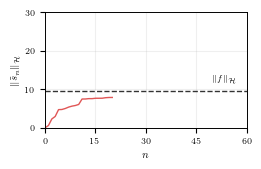

In [71]:
#noise = np.random.normal(0, 0.015, n_samples).reshape(-1,1)

delta_bar = 0.01
noise = np.random.uniform(-delta_bar, delta_bar, n_samples).reshape(-1,1)

fx = f(x_samples) 
y = fx + noise
noisy_norm = np.array([rkhs_norm_noiseless(y[0:n],x_samples[0:n]) for n in range(1,n_samples+1)]).reshape(-1,1)

plt.plot(np.arange(0, n_samples+1), np.append(0, noisy_norm), color=plot_params.polt_colors['pastel_red'])
plt.axhline(y = f.rkhs_norm, color='k', linestyle='--', alpha=0.8)

plt.xticks([0, 15, 30, 45, 60])
plt.xlim(0, 60)
plt.yticks([0, 10, 20, 30])
plt.ylim(0, 30)
plt.xlabel("$n$")
plt.ylabel("$\Vert \\tilde{s}_n \Vert_\mathcal{H}$")
plt.text(50, 12, "$\Vert f \Vert_\mathcal{H}$", fontsize=6)
plt.savefig("".join([plot_params.path_to_img_folder, "norm_value_noisy", ".pdf"]), bbox_inches='tight')#, pad_inches = 0)

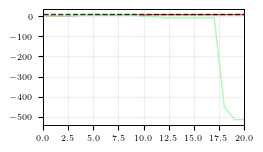

In [73]:
def norm_delta(X, y, delta_bar):
    
    k = Kernel_se()
    jitter = 1e-8
    K = k(X,X) + jitter*np.eye(X.shape[0])
    K_inv_y = np.linalg.solve(K, y)

    delta = cp.Variable(X.shape[0])    
    obj = cp.Minimize(cp.matrix_frac(delta, K) - 2*delta.T @ K_inv_y)
    constr = [cp.abs(delta) <= delta_bar]

    prob = cp.Problem(obj, constr)
    prob.solve()
    return -prob.value

noisy_norm_lower_est = np.array([rkhs_norm_noiseless(y[0:n],x_samples[0:n]) - norm_delta(x_samples[0:n],y[0:n],delta_bar) 
                                 for n in range(1,n_samples+1)]).reshape(-1,1)

plt.plot(np.arange(0, n_samples+1), np.append(0, noisy_norm), color=plot_params.polt_colors['pastel_red'])
plt.plot(np.arange(0, n_samples+1), np.append(0, noisy_norm_lower_est), color=plot_params.polt_colors['pastel_green'])
plt.axhline(y = f.rkhs_norm, color='k', linestyle='--', alpha=0.8)


-1.0900601128471143